## Initialization

In [1]:
import unet, imageGeneration, benchmark

## Define image parameters function

In [2]:
def image_parameters_function(lower_limit_SNR = 20, higher_limit_SNR = 30, image_size = 32):
    from numpy.random import uniform, randint
    from numpy import ones
    from math import pi
    
    particle_number = randint(10, 12)
    particle_radius_list = uniform(0.5, 2, particle_number)
    (particle_center_x_list, particle_center_y_list) = imageGeneration.generate_particle_positions(particle_radius_list, image_size)

    particle_bessel_orders_list = []
    particle_intensities_list = []

    for i in range(particle_number):
        particle_bessel_orders_list.append([1, ])
        particle_intensities_list.append([uniform(0.05, 0.13, 1), ])

    image_parameters = imageGeneration.get_image_parameters(
        particle_center_x_list=lambda: particle_center_x_list,
        particle_center_y_list=lambda: particle_center_y_list,
        particle_radius_list=lambda: particle_radius_list,
        particle_bessel_orders_list=lambda: particle_bessel_orders_list,
        particle_intensities_list=lambda: particle_intensities_list,
        image_size=lambda: image_size,
        image_background_level=lambda: uniform(.3, .5),
        signal_to_noise_ratio=lambda: uniform(lower_limit_SNR, higher_limit_SNR),
        gradient_intensity=lambda: uniform(0, 0),
        gradient_direction=lambda: uniform(-pi, pi),
        ellipsoidal_orientation=lambda: uniform(-pi, pi, particle_number),
        ellipticity=lambda: 1)

    return image_parameters

## Plot distance from upper left corner as function of SNR for a given cutoff value. 
SNR values are [lower_SNR:1:higher_SNR+1]

In [3]:
def plot_distance_from_upper_left_as_function_of_SNR(model, lower_SNR, higher_SNR, cutoff_value = 0.5):
    from matplotlib import pyplot as plt
    
    distances = []
    for SNR in range(lower_SNR, higher_SNR+1):
        (batch_images, batch_labels, batch_predictions) = imageGeneration.get_batch(batch_size = 10,
                                                                                    verbose = False,
                                                                                get_image_parameters_function = lambda:image_parameters_function(lower_limit_SNR = SNR,
                                                                                                                                                 higher_limit_SNR = SNR+1))
        batch_predictions = model.predict(batch_images)
        batch_predictions = imageGeneration.cutoff(batch_predictions, cutoff_value = cutoff_value, apply_sigmoid = True)
        operating_characteristics = benchmark.get_operating_characteristics(batch_labels, batch_predictions)
        distances.append(benchmark.distance_from_upper_left_corner_ROC(operating_characteristics))
    plt.plot(range(lower_SNR,higher_SNR+1), distances)
    plt.ylim(0,500)
    plt.show()

## Draw ROC as function of SNR for a given cutoff value.
SNR values are [lower_SNR:1:higher_SNR+1]

In [4]:
def plot_ROC_curve_as_function_of_SNR(model, lower_SNR, higher_SNR, cutoff_value = 0.5):
    from matplotlib import pyplot as plt
    
    TPR = []
    FPR = []
    for SNR in range(lower_SNR, higher_SNR+1):
        (batch_images, batch_labels, batch_predictions) = imageGeneration.get_batch(batch_size = 10,
                                                                                    verbose = False,
                                                                                get_image_parameters_function = lambda:image_parameters_function(lower_limit_SNR = SNR,
                                                                                                                                                 higher_limit_SNR = SNR+1))
        batch_predictions = model.predict(batch_images)
        batch_predictions = imageGeneration.cutoff(batch_predictions, cutoff_value = cutoff_value, apply_sigmoid = True)
        P, N, TP, TN, FP, FN = benchmark.get_operating_characteristics(batch_labels, batch_predictions)
        TPR.append(TP/P)
        FPR.append(FP/N)
        
    plt.plot(FPR, TPR)
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.show()

## Plot distance from upper left corner as function of cutoff for a given SNR. 
SNR values are [lower_cutoff:step:higher_cutoff)

In [5]:
def plot_distance_from_upper_left_as_function_of_cutoff(model, SNR, lower_cutoff = 0.01, higher_cutoff = 1, step = 0.01, FPR_weight = 1.0, verbose = False):
    from matplotlib import pyplot as plt
    from numpy import arange
    
    batch = imageGeneration.get_batch(batch_size = 10,
                                      verbose = False,
                                      get_image_parameters_function = lambda:image_parameters_function(lower_limit_SNR = SNR,
                                                                                                       higher_limit_SNR = SNR+1))

    (batch_images, batch_labels, batch_predictions) = batch
    batch_predictions = model.predict(batch_images)
    
    distances = []
    
    for cutoff_value in arange(lower_cutoff, higher_cutoff, step):
        if(verbose):     
            print(cutoff_value)
        batch_predictions_cutoff = imageGeneration.cutoff(batch_predictions.copy(), cutoff_value = cutoff_value, apply_sigmoid = True)
        operating_characteristics = benchmark.get_operating_characteristics(batch_labels, batch_predictions)
        print(FPR_weight)
        distances.append(benchmark.distance_from_upper_left_corner_ROC(operating_characteristics, FPR_weight))
        
    plt.plot(arange(lower_cutoff, higher_cutoff, step), distances)

## Draw ROC as function of cutoff for a given SNR.
SNR values are [lower_cutoff:step:higher_cutoff)

In [6]:
def plot_ROC_curve_as_function_of_cutoff(model, SNR, lower_cutoff = 0.01, higher_cutoff = 1, step = 0.01, FPR_weight = 1.0, verbose = False):
    from matplotlib import pyplot as plt
    from numpy import arange
    
    batch = imageGeneration.get_batch(batch_size = 10,
                                      verbose = True,
                                      get_image_parameters_function = lambda:image_parameters_function(lower_limit_SNR = SNR,
                                                                                                       higher_limit_SNR = SNR+1))
    
    (batch_images, batch_labels, batch_predictions) = batch
    imageGeneration.visualise_batch(batch, use_predictions = False)
    batch_predictions = model.predict(batch_images)

    TPR = []
    FPR = []
    
    for cutoff_value in arange(lower_cutoff, higher_cutoff, step):
        if(verbose):     
            print(cutoff_value)
        batch_predictions_cutoff = imageGeneration.cutoff(batch_predictions.copy(), cutoff_value = cutoff_value, apply_sigmoid = True)
        operating_characteristics = benchmark.get_operating_characteristics(batch_labels, batch_predictions_cutoff)
        (P, N, TP, TN, FP, FN) = operating_characteristics
        print(benchmark.distance_from_upper_left_corner_ROC(operating_characteristics, FPR_weight = FPR_weight))
        TPR.append(TP/P)
        FPR.append(FPR_weight * FP/N)
        batch = (batch_images, batch_labels, batch_predictions_cutoff)
        imageGeneration.visualise_batch(batch)
        plt.show()
        
    plt.plot(FPR, TPR, 'bo')
    plt.xlim((0,1))
    plt.ylim((0,1))


## Get operating_characteristics from upper left for a given batch and cutoff

In [17]:
def get_operating_characteristics(batch, cutoff,image_size_x, image_size_y,scanning_box_size_x, scanning_box_size_y, step_x, step_y):
    import time
    
    (batch_images, batch_labels, batch_predictions, batch_particle_positions_and_radii_and_intensities) = batch
    
    batch_predictions_after_cutoff = imageGeneration.cutoff(batch_predictions.copy(), cutoff, apply_sigmoid = True)
    
    operating_characteristics_sum = [0,0,0,0,0,0]
    for batch_index in range(len(batch_predictions)):
        current_particle_positions_x = batch_particle_positions_and_radii_and_intensities[batch_index][0]
        current_particle_positions_y = batch_particle_positions_and_radii_and_intensities[batch_index][1]
        
        current_prediction = batch_predictions_after_cutoff[batch_index].copy()
        current_particle_positions_and_radii_and_intensities = imageGeneration.get_particle_positions_radii_and_intensities(current_prediction)
        current_predicted_particle_positions_x = current_particle_positions_and_radii_and_intensities[0]
        current_predicted_particle_positions_y = current_particle_positions_and_radii_and_intensities[1]
        
        current_operating_characteristics_optimized = benchmark.get_operating_characteristics_scanning_box_optimized(current_predicted_particle_positions_x,
                                                                                                 current_predicted_particle_positions_y,
                                                                                                 current_particle_positions_x, 
                                                                                                 current_particle_positions_y,
                                                                                                 image_size_x, image_size_y,
                                                                                                 scanning_box_size_x, 
                                                                                                 scanning_box_size_y,
                                                                                                 step_x, step_y)
        operating_characteristics_sum = [sum(x) for x in zip(operating_characteristics_sum, current_operating_characteristics_optimized)]
    
    operating_characteristics = [x / len(batch_predictions) for x in operating_characteristics_sum]
    return tuple(operating_characteristics)

        
        




        

## Benchmark models

In [8]:
# import glob, os
# from matplotlib import pyplot as plt
# from scipy.ndimage import zoom
# import numpy as np

# lower_limit_SNR = 15
# higher_limit_SNR = 16
# batch = imageGeneration.get_batch(batch_size = 10,
#                                   get_image_parameters_function = lambda:image_parameters_function(lower_limit_SNR = lower_limit_SNR,
#                                                                                                    higher_limit_SNR = higher_limit_SNR))
# (batch_images, batch_labels, batch_predictions) = batch

# model = unet.create_unet()

# plt.imshow(zoom(batch_images[0,:,:,0],5.0), cmap = 'gray', vmin = 0, vmax = 1)
# plt.colorbar()
# plt.show()

# imageGeneration.visualise_batch((batch_images, batch_labels, batch_predictions), use_predictions = False)
# plt.show()

# for filename in glob.iglob('C:\School\Årskurs 3\Kandidat\DeepTrack\DeepTrack 1.0\\NewNetwork' + '\*\*.hdf5', recursive=True):
    
#     #Prints current filename
#     filenameList = filename.split('\\')
#     print("Filename is %s."% ('\\'.join(filenameList[len(filenameList)-2:len(filenameList)])))
    

#     TPR = []
#     FPR = []
#     TPRoverFPR = []
#     lower_SNR = 10
#     upper_SNR = 30
#     for SNR in range(lower_SNR, upper_SNR):
#         model.load_weights(filename)
#         #Generate batch for cutoff
#         (batch_images, batch_labels, batch_predictions) = imageGeneration.get_batch(batch_size = 10,
#                                                                                     get_image_parameters_function = lambda:image_parameters_function(lower_limit_SNR = SNR,
#                                                                                                                                              higher_limit_SNR = SNR+1),
#                                                                                     verbose = False)
#         #Generate predictions for cutoff and find optimal cutoff for current SNR
#         batch_predictions = model.predict(batch_images)
#         optimal_cutoff = unet.get_optimal_cutoff(batch_labels, batch_predictions, sample_size = 10, apply_sigmoid = True)
#         print("SNR is %d, optimal_cutoff is %.10f" % (SNR, optimal_cutoff))
        
#         #Generate batch for benchmarking
#         (batch_images, batch_labels, batch_predictions) = imageGeneration.get_batch(batch_size = 10,
#                                                                                     get_image_parameters_function = lambda:image_parameters_function(lower_limit_SNR = SNR,
#                                                                                                                                              higher_limit_SNR = SNR+1),
#                                                                                     verbose = False)
#         #Generate predictions for benchmarking
#         batch_predictions = model.predict(batch_images)
#         batch_predictions = imageGeneration.cutoff(batch_predictions, cutoff_value = optimal_cutoff, apply_sigmoid = True)

#         #Get TPR and FPR
#         P, N, TP, TN, FP, FN = benchmark.get_operating_characteristics(batch_labels, batch_predictions)
#         print("P is %d, N is %d, TP is %d, TN is %d, FP is %d, FN is %d" % (P, N, TP, TN, FP, FN))

#         TPR.append(TP/P)
#         FPR.append(FP/N)
#         TPRoverFPR.append((TP/P)/(FP/N))
        
#     # Draw ROC curve for current model
#     plt.plot(FPR,TPR)
#     plt.ylim(0,1)
#     plt.xlim(0,0.2)
#     plt.show()
    
#     # Draw TPR/FPR ratio as function of SNR for current model
#     TPRoverFPR = np.asarray(TPR)/np.asarray(FPR)
#     plt.plot(range(lower_SNR, upper_SNR), TPRoverFPR)
#     plt.ylim(0,450)
#     plt.show()
    



In [9]:
# from matplotlib import pyplot as plt
# SNR = 20
# model = unet.create_unet("unet_particle.hdf5")
# print("ASD")
# plot_ROC_curve_as_function_of_cutoff(model, SNR, lower_cutoff = 0.8, higher_cutoff = 1, step = 0.005, verbose = True, FPR_weight = 100.0)
# plt.show()

In [10]:
# image_size = 64

# test_batch = imageGeneration.get_batch(get_image_parameters_function = lambda:image_parameters_function(image_size = image_size,
#                                                                                                        lower_limit_SNR = 50,
#                                                                                                        higher_limit_SNR = 50), 
#                                        batch_size = 1, include_particle_positions_radii_and_intensities = True)

# batch_images, batch_labels, batch_predictions, batch_particle_positions_and_radii_and_intensities = test_batch

# image_0_particle_positions_and_radii_and_intensities = batch_particle_positions_and_radii_and_intensities[0]
# particle_positions_x = image_0_particle_positions_and_radii_and_intensities[0]
# particle_positions_y = image_0_particle_positions_and_radii_and_intensities[1]
# model = unet.create_unet("unet_particle.hdf5")
# particle_positions_x, particle_positions_y = zip(*sorted(zip(particle_positions_x, particle_positions_y)))
# print(particle_positions_x)
# print(particle_positions_y)

# batch_predictions = model.predict(batch_images)
# batch_predictions_after_cutoff = imageGeneration.cutoff(batch_predictions, 0.97, apply_sigmoid = True)

# prediction_0 = batch_predictions_after_cutoff[0]
# prediction_0_particle_positions_and_radii_and_intensities = imageGeneration.get_particle_positions_radii_and_intensities(prediction_0)
# predicted_particle_positions_x = prediction_0_particle_positions_and_radii_and_intensities[0]
# predicted_particle_positions_y = prediction_0_particle_positions_and_radii_and_intensities[1]
# predicted_particle_positions_x, predicted_particle_positions_y = zip(*sorted(zip(predicted_particle_positions_x, predicted_particle_positions_y)))
# print(predicted_particle_positions_x)
# print(predicted_particle_positions_y)



In [11]:
# from skimage import measure     
# from statistics import mean     
# from numpy import argwhere      
# from matplotlib import pyplot as plt



# plt.imshow(batch_labels[0,:,:,0])
# plt.show()

# plt.imshow(prediction_0[:,:,0])
# plt.show()


In [12]:
# from numpy import arange
# import time
# from matplotlib import pyplot

# image_size_x = image_size
# image_size_y = image_size
# scanning_box_size_x = 2
# scanning_box_size_y = 2
# scanning_box_step_x = 0.02
# scanning_box_step_y = 0.02

# TPRs = []
# FPRs = []
# times = []
# for step in arange(0.1, 1, 0.01):
#     time_0 = time.time()
#     operating_characteristics = benchmark.get_operating_characteristics_scanning_box(predicted_particle_positions_x, predicted_particle_positions_y,
#                                                                        particle_positions_x, particle_positions_y,
#                                                                        image_size_x, image_size_y,
#                                                                        scanning_box_size_x, scanning_box_size_y,
#                                                                                      step, step)
#     P, N, TP, TN, FP, FN = operating_characteristics
#     time_1 = time.time() - time_0
    
#     times.append(time_1)
#     TPRs.append(TP/P)
#     FPRs.append(FP/N)
#     print("Step: %.3f, time: %.5f, TPR: %.4f, FPR: %.10f" % (step, time_1, TP/P, FP/N))




                                                                       


In [20]:
from numpy import arange
from matplotlib import pyplot as plt

image_size = 128
batch = imageGeneration.get_batch(batch_size = 10,
                                  verbose = False,
                                  get_image_parameters_function = lambda:image_parameters_function(image_size = image_size,
                                                                                                   lower_limit_SNR = 10,
                                                                                                   higher_limit_SNR = 50),
                                 include_particle_positions_radii_and_intensities=True)

(batch_images, batch_labels, batch_predictions, batch_particle_positions_and_radii_and_intensities) = batch
model = unet.create_unet("unet_particle.hdf5")
batch_predictions = model.predict(batch_images)

batch = (batch_images,batch_labels,batch_predictions, batch_particle_positions_and_radii_and_intensities)

0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.010000000000000002
0.011
0.012
0.013000000000000001
0.014000000000000002
0.015
0.016
0.017
0.018000000000000002
0.019000000000000003
0.02
0.021
0.022000000000000002
0.023
0.024
0.025
0.026000000000000002
0.027000000000000003
0.028
0.029
0.030000000000000002
0.031
0.032
0.033
0.034
0.035
0.036000000000000004
0.037000000000000005
0.038
0.039
0.04
0.041
0.042
0.043000000000000003
0.044000000000000004
0.045
0.046
0.047
0.048
0.049
0.05
0.051000000000000004
0.052000000000000005
0.053000000000000005
0.054
0.055
0.056
0.057
0.058
0.059000000000000004
0.060000000000000005
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.07100000000000001
0.07200000000000001
0.07300000000000001
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.08600000000000001
0.08700000000000001
0.08800000000000001
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1
0.101
0.10200000000000001
0.10300000000

0.997
0.998
0.999


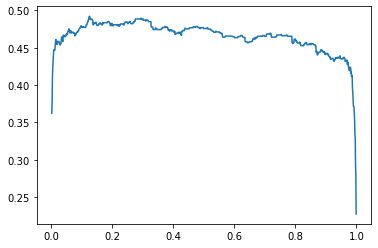

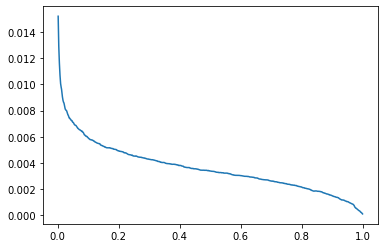

In [38]:
cutoffs = arange(0.001, 1, 0.001)
TPRs = []
FPRs = []
for cutoff in cutoffs:
    print(cutoff)
    operating_characteristics = get_operating_characteristics(batch, cutoff = cutoff, image_size_x = image_size, image_size_y = image_size, scanning_box_size_x = 1.25, scanning_box_size_y = 1.25, step_x = 0.2, step_y = 0.2)
    P,N,TP,FP,TN,FN = operating_characteristics
    TPRs.append(TP/P)
    FPRs.append(FP/N)
plt.plot(cutoffs, TPRs)
plt.show()
plt.plot(cutoffs, FPRs)
plt.show()

In [39]:
P,N,TP,FP,TN,FN = operating_characteristics
TPR = TP/P
FPR = FP/N
print(TP/P, FP/N)
print(benchmark.distance_from_upper_left_corner_ROC(operating_characteristics))

0.22763443453098628 0.00010401918719556079
0.772435606788888


In [40]:
weight = 100
distances = [((1-TPR)**2 + (FPR*weight)**2)**(0.5) for TPR, FPR in zip(TPRs,FPRs)]
print(min(distances))
print("%.4f" % cutoffs[distances.index(min(distances))])


0.5703872864565657
0.9600


(0, 1)

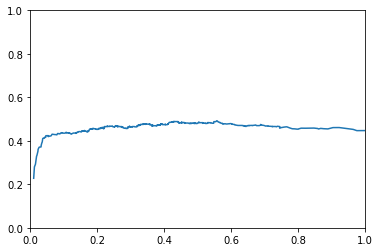

In [41]:

plt.show()
plt.plot([weight*x for x in FPRs], TPRs)
plt.xlim(0, 1)
plt.ylim(0, 1)


In [ ]:
import scipy
n = scipy.sparse.rand(10000, 10000, density=0.01, format = 'csr')>0
m = scipy.sparse.rand(10000, 10000, density = 0.01, format = 'csr')>0

In [ ]:
import time
time_0 = time.time()
P = scipy.sparse.csr_matrix.sum(n)
N = 10000*10000 - scipy.sparse.csr_matrix.sum(n>0)
TP = scipy.sparse.csr_matrix.sum(scipy.sparse.csr_matrix.minimum(n, m))
FP = scipy.sparse.csr_matrix.sum(scipy.sparse.csr_matrix.maximum(n, m) - n)

n_new = n>0
m_new = m>0
TN = 10000*10000 - scipy.sparse.csr_matrix.sum(n_new + m_new)

FN = P - TP

print(time.time()-time_0)
print(P, N, TP, FP, TN, FN)
assert(P == (TP + FN))
assert(N == (FP + TN))

In [ ]:
import numpy as np
n_np = np.asarray(n)
m_np = np.asarray(m)
time_0 = time.time()
P = sum(n)
print(time.time()-time_0)

In [ ]:
n = scipy.sparse.rand(100, 100, density=0.1, format = 'csr')>0
m = scipy.sparse.rand(100, 100, density = 0.1, format = 'csr')>0

In [ ]:
print(n)
print(m)
print(n + m)
print(n.data.nbytes)
print(m.data.nbytes)
print((n+m).data.nbytes)

In [ ]:
from numpy import arange, ceil
from numpy.random import uniform
for i in range(10000000):
    image_size_y = uniform(200)
    scanning_box_size_y = uniform(image_size_y)
    scanning_box_step_y = uniform(image_size_y)
#     print(arange(scanning_box_size_y, image_size_y + scanning_box_step_y, scanning_box_step_y))

#     print(len(arange(scanning_box_size_y, image_size_y + scanning_box_step_y, scanning_box_step_y)))

#     print(ceil((image_size_y + scanning_box_step_y - scanning_box_size_y)/scanning_box_step_y))
    assert(len(arange(scanning_box_size_y, image_size_y + scanning_box_step_y, scanning_box_step_y)) == ceil((image_size_y + scanning_box_step_y - scanning_box_size_y)/scanning_box_step_y))


In [ ]:
from scipy import sparse
scanning_boxes_matrix_particles = sparse.csr_matrix((10000, 10000))
scanning_boxes_matrix_particles[1, 1] += 1
print(scanning_boxes_matrix_particles.data.nbytes)
print(scanning_boxes_matrix_particles)

